# import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import re
import nltk
from nltk.tokenize import word_tokenize
from datetime import datetime
from dateutil import parser
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from nrclex import NRCLex
from numpy import array
from keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D
from keras.models import model_from_json
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.layers import Embedding, LSTM, Dense, Dropout, Layer, TimeDistributed, Bidirectional
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from keras.layers import Input
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K
import seaborn as sns
from string import punctuation
import regex as re
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import model_from_json

[nltk_data] Downloading package stopwords to /home/fazal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fazal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fazal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fazal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
2024-01-21 10:40:32.523367: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 10:40:32.562113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 10:40:32.562585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-criti

In [2]:
afinn = dict(map(lambda kv: (kv[0], int(kv[1])), [ line.split('\t') for line in open("/home/fazal/miniconda3/envs/Touride/Assignment/Model/AFINN-111.txt")]))
SS = pd.read_csv('/home/fazal/miniconda3/envs/Touride/Assignment/Model/Sentiment.csv', usecols=['sentiment'], encoding="ISO-8859-1")
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b',max_features=100)


# FEATURE METHODS AND INITIALIZATIONS 

In [3]:
def prepare_features(review):
  dat = NRCLex(review).affect_frequencies
  freq = []
  freq.append(dat['fear'])
  freq.append(dat['anger'])
  if 'anticipation' in dat.keys():
    freq.append(dat['anticipation'])
  else:
    freq.append(dat['anticip'])
  freq.append(dat['trust'])
  freq.append(dat['surprise'])
  freq.append(dat['sadness'])
  freq.append(dat['disgust'])
  freq.append(dat['joy'])
  if sum(dat.values()) == 0:
    freq.append(1)
  else:
    freq.append(0)
  return np.array(freq)

def prepare_polarity_value(review):
    features = []
    features.append(sum(map(lambda word: afinn.get(word, 0), review.lower().split())))
    return np.array(features)

def prepare_statistical_affective(review):
    verbs = adjectives = adverbs = nouns = 0
    tweeth_length = len(review)

    hashes = sum(map(lambda x : 1 if '#' in x else 0, review))
    mentions = sum(map(lambda x : 1 if '@' in x else 0, review))
    qmarks = sum(map(lambda x : 1 if '?' in x else 0, review))
    exmarks = sum(map(lambda x : 1 if '!' in x else 0, review))
    colons = sum(map(lambda x : 1 if ':' in x else 0, review))

    punctuation_counts = 0
    for i in review:
        if i in punctuation:
            punctuation_counts += 1
    capital_count = sum(1 for c in review if c.isupper())
    emoticons = len(re.findall(r'[^\w\s,.]', review))
    text = word_tokenize(review)
    grammar = nltk.pos_tag(text)
    for item in grammar:
        if ("VB" in item[1]):
          verbs += 1
        if ("NN" in item[1]):
          nouns += 1
        if ("JJ" in item[1]):
          adjectives += 1
        if ("RB" in item[1]):
          adverbs += 1
    features = [tweeth_length,punctuation_counts,capital_count, emoticons, verbs, adjectives, adverbs, nouns, hashes, mentions, qmarks, exmarks, colons]
    return np.array(features)

def prepare_semantic_similarity(review):
  list1 = review.split(" ")
  list2 = review.split(" ")
  wordnet_similarity_index = 0
  for word1 in list1:
      for word2 in list2:
          if (word1 != word2):
            wordFromList1 = wordnet.synsets(word1)
            wordFromList2 = wordnet.synsets(word2)
            if wordFromList1 and wordFromList2:
                try:
                  s = wordFromList1[0].wup_similarity(wordFromList2[0])
                  wordnet_similarity_index += s
                except Exception:
                  pass
  features = [wordnet_similarity_index]
  return np.array(features)

def prepare_semantic_score_feature(review):
  sentiment_score = 0
  data_dict = {}
  for ch in review:
    if (ch in data_dict):
      sentiment_score += data_dict[ch]
    else:
      row = SS.loc[SS['Character'] == ch.upper()]
      if (not row.empty):
        sc = row.iloc[0]["Score"]
        sentiment_score += sc
        data_dict[ch] = sc
      else:
        data_dict[ch] = 0

  return np.array([sentiment_score])

def evaluate_model(actual, prediction):
    acc = (accuracy_score(actual, prediction))
    f1 = f1_score(actual, prediction, average='weighted')
    rec = recall_score(actual, prediction, average='macro')
    precision = precision_score(actual, prediction, average='micro')
    print(f"Perc. Score {round(acc*100, 2)}%")
    print(f"F1 Score {round(f1*100, 2)}%")
    print(f"Recall {round(rec, 4)}")
    print(f"Precision {round(precision, 2)}")
    
    for p in [0,1,2]:
      fpr, tpr, thresholds = metrics.roc_curve(actual, prediction, pos_label = p) 
      auroc = round(metrics.auc(fpr, tpr),2)
      print('Class ',p,'--ROC--->',auroc)

    cm = confusion_matrix(actual, prediction)
    print('Confusion Metric')
    print(cm)
    print("******************************************")

def filter_sentence(review):
    review = review = re.sub('[^a-zA-Z]', ' ', str(review))
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    return review

# Load and prepare DATASET and LABELS

In [4]:
df = pd.read_csv('/home/fazal/miniconda3/envs/Touride/Assignment/Preprocessing/booking.csv',  encoding = "ISO-8859-1")

In [5]:
reviews = df['review_content']
print(reviews)

0        Closer to the main road, good on site restaura...
1                                                     Good
2        Very convenient location, good spacious rooms ...
3        Location good, Good food, Nice Staff, Restaura...
4        Its a very good hotel with comfortable and new...
                               ...                        
66446    I stayed there for two nights. The Room and ba...
66447    If you are heading to Mirissa, then you should...
66448    The guest house was so clean and well located ...
66449    We really enjoyed our stay at Suriya guesthous...
66450    Suriya Guest is a small family guest with 1 ro...
Name: review_content, Length: 66451, dtype: object


In [6]:
conditions = [
    (df['rating'] < 5),
    (df['rating'] >= 5) & (df['rating'] < 7),
    (df['rating'] >= 7),
]

print(len(conditions[1]))
print(len(conditions[2]))
values = [0, 1, 2]

df['rating_class'] = np.select(conditions, values)
y = pd.get_dummies(df['rating_class'], sparse=True)
print(y)

66451
66451
           0      1     2
0      False  False  True
1      False  False  True
2      False  False  True
3      False  False  True
4      False  False  True
...      ...    ...   ...
66446  False  False  True
66447  False  False  True
66448  False  False  True
66449  False  False  True
66450  False  False  True

[66451 rows x 3 columns]


In [7]:
print(df)

             hotel_name  rating  \
0      the-lion-pub-amp    10.0   
1      the-lion-pub-amp    10.0   
2      the-lion-pub-amp    10.0   
3      the-lion-pub-amp    10.0   
4      the-lion-pub-amp    10.0   
...                 ...     ...   
66446      suriya-guest    10.0   
66447      suriya-guest    10.0   
66448      suriya-guest    10.0   
66449      suriya-guest    10.0   
66450      suriya-guest    10.0   

                                          review_content  Unnamed: 3  \
0      Closer to the main road, good on site restaura...         NaN   
1                                                   Good         NaN   
2      Very convenient location, good spacious rooms ...         NaN   
3      Location good, Good food, Nice Staff, Restaura...         NaN   
4      Its a very good hotel with comfortable and new...         NaN   
...                                                  ...         ...   
66446  I stayed there for two nights. The Room and ba...         NaN   
664

In [8]:
columns_to_keep = ['hotel_name', 'rating', 'review_content', 'rating_class']

df = df.drop(df.columns.difference(columns_to_keep), axis=1)

# Display the modified DataFrame
print(df)


             hotel_name  rating  \
0      the-lion-pub-amp    10.0   
1      the-lion-pub-amp    10.0   
2      the-lion-pub-amp    10.0   
3      the-lion-pub-amp    10.0   
4      the-lion-pub-amp    10.0   
...                 ...     ...   
66446      suriya-guest    10.0   
66447      suriya-guest    10.0   
66448      suriya-guest    10.0   
66449      suriya-guest    10.0   
66450      suriya-guest    10.0   

                                          review_content  rating_class  
0      Closer to the main road, good on site restaura...             2  
1                                                   Good             2  
2      Very convenient location, good spacious rooms ...             2  
3      Location good, Good food, Nice Staff, Restaura...             2  
4      Its a very good hotel with comfortable and new...             2  
...                                                  ...           ...  
66446  I stayed there for two nights. The Room and ba...            

# PREPROCESSING SENTENCES AND PREPARE EMOTIONAL LEXICON FEATURES

In [9]:
X = []
X_ss = []
X_pv =[]
X_st_aff = []
X_semantic_aff = []
X_cred = []
words = []

for i in range(0, len(reviews)):
      reviews[i] = str(reviews[i])
      filtered_review = filter_sentence(reviews[i])
      words.append(filtered_review)
      X.append(prepare_features(filtered_review))
      X_pv.append(prepare_polarity_value(filtered_review))
      X_st_aff.append(prepare_statistical_affective(reviews[i]))
      

vec = vectorizer.fit_transform(np.array(words)).toarray()
with open('vector.pkl', 'wb') as fw:
     pickle.dump(vectorizer.vocabulary_, fw)

# WORD CLOUD REPRESENTATION

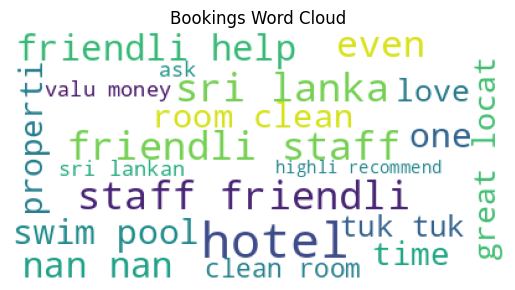

In [10]:
def show_word_cloud(text_array, title):
  text = ' '.join([str(elem) for elem in text_array])
  wordcloud = WordCloud().generate(text)
  wordcloud = WordCloud(background_color="white",max_words=20,max_font_size=40, relative_scaling=.5).generate(text)
  plt.figure()
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(title)
  plt.show()

show_word_cloud(words, "Bookings Word Cloud")
print("\n\n")

# SPLIT TRAIN AND TEST DATASET

In [11]:
X=np.array(X)
X_pv = np.array(X_pv)
X_ss = np.array(X_ss)
X_pv = np.array(X_pv)
X_semantic_aff = np.array(X_semantic_aff)
X_st_aff = np.array(X_st_aff)
X_cred = np.array(X_cred)
vec = np.array(vec)
 
y=np.array(y)

X = np.hstack((X, X_pv, X_st_aff, vec))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [12]:
# saving the train and test data
np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)

# DEFINE & TRAIN ON CNN MODEL FOR FEATURES TRAINING

In [13]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        elmo_model = hub.KerasLayer('https://tfhub.dev/google/elmo/2',
                           name="{}_module".format(self.name))
        sess = tf.compat.v1.Session()
        self.elmo = elmo_model
        self._trainable_weights += tf.compat.v1.trainable_variables(
                  scope="^elmo_module/.*")
        super(ElmoEmbeddingLayer, self).build(input_shape)

In [14]:
input_text = layers.Input(shape=(X_train.shape[1],))
embedding = ElmoEmbeddingLayer()(input_text)
dense = layers.Dense(5024, activation='relu')(embedding)
reg = Dropout(0.2)(dense)
dense = layers.Dense(1024, activation='relu')(reg)
dense = layers.Dense(256, activation='relu')(dense)
dense = layers.Dense(312, activation='relu')(dense)
reg = Dropout(0.2)(dense)
dense = layers.Dense(32, activation='relu')(reg)
pred = layers.Dense(3, activation='softmax')(dense)

model = keras.Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

'''
model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
'''

model.fit(X_train, y_train, validation_split=0.33, epochs=100, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 123)]             0         
                                                                 
 elmo_embedding_layer (Elmo  (None, 123)               93600852  
 EmbeddingLayer)                                                 
                                                                 
 dense (Dense)               (None, 5024)              622976    
                                                                 
 dropout (Dropout)           (None, 5024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5145600   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                             

In [15]:
model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("cnn_model.h5")

In [16]:
model.load_weights('cnn_model.h5')
print("## TESTING METRICS ##")
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=-1)
pred = np.argmax(pred, axis=-1)

## TESTING METRICS ##
Shape of X_test: (13291, 123)
Shape of y_test: (13291, 3)
416/416 [==============================] - 2s 6ms/step


# Testing Metrics

In [17]:
evaluate_model(y_test,pred)

Perc. Score 89.19%
F1 Score 85.92%
Recall 0.4492
Precision 0.89
Class  0 --ROC---> 0.32
Class  1 --ROC---> 0.45
Class  2 --ROC---> 0.6
Confusion Metric
[[  174    20   329]
 [   96    26   851]
 [   71    70 11654]]
******************************************
